<a href="https://colab.research.google.com/github/JohnPoma/Lung_cancer_projet/blob/main/xception_ok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: code pour monter drive dans colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# prompt: afficher le nombre de images par classe dans le repertoire de train

#from google.colab import drive
import os
import shutil
import random

#drive.mount('/content/drive')


# Replace with the actual path to your dataset directory in Google Drive
train_dataset_path = '/content/drive/My Drive/Deeplearning/lung_image_sets_split/train'

if os.path.exists(train_dataset_path):
  class_counts = {}
  for root, _, files in os.walk(train_dataset_path):
    for file in files:
      class_name = os.path.basename(root)  # Assuming class is represented by directory name
      if class_name not in class_counts:
        class_counts[class_name] = 0
      class_counts[class_name] += 1


  print("\nNumber of data points per class in train directory:")
  for class_name, count in class_counts.items():
    print(f"- {class_name}: {count}")

else:
  print(f"Dataset directory '{train_dataset_path}' not found.")


Number of data points per class in train directory:
- lung_n: 3500
- lung_aca: 3500
- lung_scc: 3500


In [3]:
# prompt: afficher le nombre de données par classe du repertoire de test et validation

# Replace with the actual path to your dataset directory in Google Drive
test_dataset_path = '/content/drive/My Drive/Deeplearning/lung_image_sets_split/test'
val_dataset_path = '/content/drive/My Drive/Deeplearning/lung_image_sets_split/val'


if os.path.exists(test_dataset_path):
  class_counts = {}
  for root, _, files in os.walk(test_dataset_path):
    for file in files:
      class_name = os.path.basename(root)  # Assuming class is represented by directory name
      if class_name not in class_counts:
        class_counts[class_name] = 0
      class_counts[class_name] += 1


  print("\nNumber of data points per class in test directory:")
  for class_name, count in class_counts.items():
    print(f"- {class_name}: {count}")

else:
  print(f"Dataset directory '{test_dataset_path}' not found.")

if os.path.exists(val_dataset_path):
  class_counts = {}
  for root, _, files in os.walk(val_dataset_path):
    for file in files:
      class_name = os.path.basename(root)  # Assuming class is represented by directory name
      if class_name not in class_counts:
        class_counts[class_name] = 0
      class_counts[class_name] += 1


  print("\nNumber of data points per class in validation directory:")
  for class_name, count in class_counts.items():
    print(f"- {class_name}: {count}")

else:
  print(f"Dataset directory '{val_dataset_path}' not found.")


Number of data points per class in test directory:
- lung_n: 750
- lung_aca: 750
- lung_scc: 750

Number of data points per class in validation directory:
- lung_n: 750
- lung_aca: 750
- lung_scc: 750


In [4]:
# prompt: applique la data augmentation sur les données d'entrainement

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Chemin vers le répertoire contenant les données d'entraînement
train_data_dir = '/content/drive/My Drive/Deeplearning/lung_image_sets_split/train'

# Créer un générateur d'augmentation de données
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    rescale=1./255,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Appliquer l'augmentation de données sur les données d'entraînement
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)  # You might want to apply the same preprocessing as training data

val_generator = val_datagen.flow_from_directory(
    val_dataset_path,
    target_size=(224, 224),
    batch_size=32,  # Adjust batch size if needed
    shuffle=False,
    class_mode='categorical'
)
test_datagen = ImageDataGenerator(rescale=1./255)  # You might want to apply the same preprocessing as training data

test_generator = test_datagen.flow_from_directory(
    test_dataset_path,
    target_size=(224, 224),
    batch_size=32,  # Adjust batch size if needed,
    shuffle=False,
    class_mode='categorical'
)

Found 10500 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.


In [5]:
#from tensorflow.keras.applications import MobileNet
#from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.xception import Xception
#from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Charger MobileNet avec les poids pré-entraînés d'ImageNet sans la couche de sortie
#base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Ajout de la couche GlobalAveragePooling2D pour combiner les features
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Ajouter la dernière couche de classification pour 3 classes
output_layer = Dense(3, activation='softmax')(x)

# Créer un nouveau modèle
model = Model(inputs=base_model.input, outputs=output_layer)

# Geler les couches de base de MobileNet pour ne pas les entraîner
for layer in base_model.layers:
    layer.trainable = False

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.00005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks pour stopper l'entraînement tôt si la validation stagne et pour réduire le LR
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]




83683744/83683744 [==============================] - 0s 0us/step


In [6]:
# Entraînement du modèle
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/10
329/329 [==============================] - 3047s 9s/step - loss: 0.9389 - accuracy: 0.5733 - val_loss: 0.7915 - val_accuracy: 0.7462 - lr: 5.0000e-05
Epoch 2/10
329/329 [==============================] - 276s 837ms/step - loss: 0.7265 - accuracy: 0.7467 - val_loss: 0.6444 - val_accuracy: 0.8142 - lr: 5.0000e-05
Epoch 3/10
329/329 [==============================] - 275s 836ms/step - loss: 0.6127 - accuracy: 0.8123 - val_loss: 0.5482 - val_accuracy: 0.8556 - lr: 5.0000e-05
Epoch 4/10
329/329 [==============================] - 279s 847ms/step - loss: 0.5429 - accuracy: 0.8322 - val_loss: 0.4857 - val_accuracy: 0.8773 - lr: 5.0000e-05
Epoch 5/10
329/329 [==============================] - 276s 840ms/step - loss: 0.4887 - accuracy: 0.8538 - val_loss: 0.4433 - val_accuracy: 0.8836 - lr: 5.0000e-05
Epoch 6/10
329/329 [==============================] - 277s 842ms/step - loss: 0.4505 - accuracy: 0.8674 - val_loss: 0.4065 - val_accuracy: 0.8951 - lr: 5.0000e-05
Epoch 7/10
329/329 [====

In [7]:
# prompt: sauvegarder le modele
import os  # Import os module for file operations

# Specify the path where you want to save the model
model_save_path = '/content/drive/My Drive/Deeplearning/saved_model/exception.keras'  # Added .keras extension

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)  # Create parent directories if needed

# Save the model
model.save(model_save_path)

print(f"Model saved to: {model_save_path}")# prompt: sauvegarder le modele
import os  # Import os module for file operations

# Specify the path where you want to save the model
model_save_path = '/content/drive/My Drive/Deeplearning/saved_model/exception.keras'  # Added .keras extension

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)  # Create parent directories if needed

# Save the model
model.save(model_save_path)

print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/My Drive/Deeplearning/saved_model/exception.keras
Model saved to: /content/drive/My Drive/Deeplearning/saved_model/exception.keras


In [8]:
# prompt: print for validation data the accuracy and loss

# ... (Your existing code) ...

# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(val_generator)

print('Validation accuracy:', val_accuracy)
print('Validation loss:', val_loss)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator)

print('Test accuracy:', accuracy)
print('Test loss:', loss)
#accuracy for train
loss, accuracy = model.evaluate(train_generator)

print('Train accuracy:', accuracy)
print('Train loss:', loss)

71/71 [==============================] - 33s 457ms/step - loss: 0.3257 - accuracy: 0.9076
Validation accuracy: 0.9075555801391602
Validation loss: 0.3257407248020172
71/71 [==============================] - 534s 8s/step - loss: 0.3334 - accuracy: 0.9018
Test accuracy: 0.9017778038978577
Test loss: 0.3333573043346405
329/329 [==============================] - 244s 740ms/step - loss: 0.3500 - accuracy: 0.8930
Train accuracy: 0.8930476307868958
Train loss: 0.3500400483608246


71/71 [==============================] - 33s 446ms/step
              precision    recall  f1-score   support

    lung_aca       0.87      0.83      0.85       750
      lung_n       0.97      0.99      0.98       750
    lung_scc       0.86      0.89      0.87       750

    accuracy                           0.90      2250
   macro avg       0.90      0.90      0.90      2250
weighted avg       0.90      0.90      0.90      2250



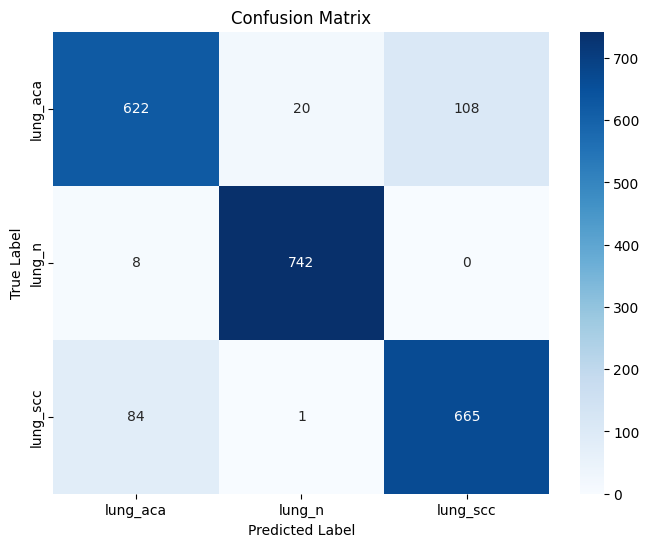

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions for the test data
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels for the test data
y_true = test_generator.classes  # Assign the true labels to y_true

# Get class names from the generator
class_names = list(test_generator.class_indices.keys()) # Assuming test_generator has class_indices

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=class_names)

# Print the classification report
print(report)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# You can also visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

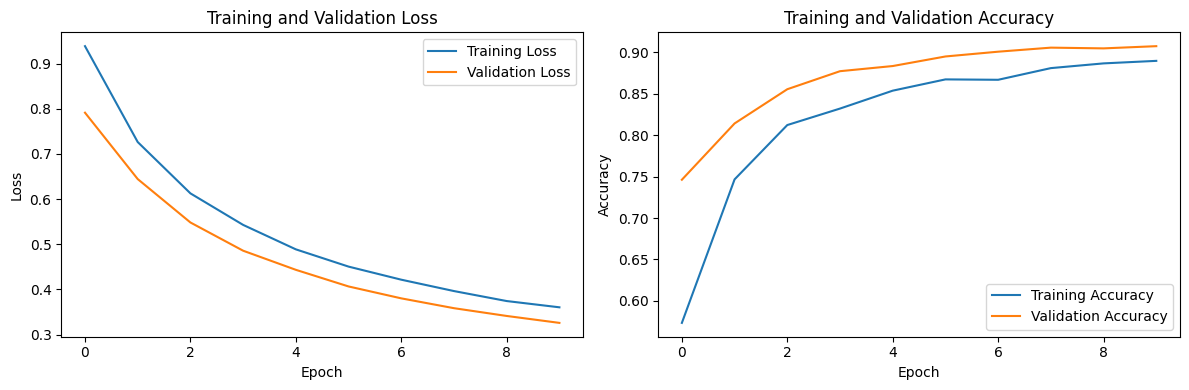

In [10]:
# affiche la courbe de validation et de perte

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

71/71 [==============================] - 32s 447ms/step


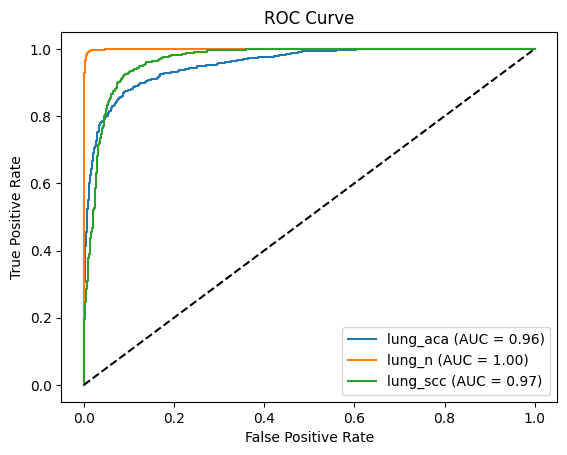

In [11]:
#  ROC AUC

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get predicted probabilities for each class
Y_pred_proba = model.predict(test_generator)

# Assuming you have 3 classes (e.g., 'normal', 'pneumonia', 'COVID-19')
# You can adjust the number of classes and labels accordingly
n_classes = 3
class_labels = list(test_generator.class_indices.keys())

# Calculate ROC AUC for each class
for i in range(n_classes):
    fpr, tpr, thresholds = roc_curve(test_generator.classes == i, Y_pred_proba[:, i])
    auc = roc_auc_score(test_generator.classes == i, Y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [12]:
# calcul de recall

from sklearn.metrics import recall_score

# Assuming you have y_true and y_pred defined as in your previous code:
# y_true = test_generator.classes
# y_pred = np.argmax(Y_pred, axis=1)

# Calculate the recall for each class
recall = recall_score(y_true, y_pred, average=None)

# Print the recall for each class
class_names = list(test_generator.class_indices.keys())
for i, class_name in enumerate(class_names):
  print(f"Recall for {class_name}: {recall[i]}")


# Calculate the average recall across all classes
average_recall = recall_score(y_true, y_pred, average='macro')
print(f"Average Recall: {average_recall}")

Recall for lung_aca: 0.8293333333333334
Recall for lung_n: 0.9893333333333333
Recall for lung_scc: 0.8866666666666667
Average Recall: 0.9017777777777778


In [13]:
# prompt: calculer la sensitivité et la précision du modèle

from sklearn.metrics import confusion_matrix

# Assuming you have y_true and y_pred from your model's evaluation

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Extract true positive (TP), true negative (TN), false positive (FP), false negative (FN)
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]

# Calculate sensitivity (recall)
sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0

# Calculate precision
precision = TP / (TP + FP) if (TP + FP) > 0 else 0

print(f"Sensitivity: {sensitivity:.4f}")
print(f"Precision: {precision:.4f}")

Sensitivity: 0.9893
Precision: 0.9738
